# AttentiveFP

The AttentiveFP is introduced in 2020, a graph-based neural network framework that captures the atomic local environment by propagating node information from neighbouring nodes to distant ones but also enables nonlocal effects at the intramolecular level by employing a graph attention mechanism. Their findings demonstrate that the AttentiveFP can effectively extract nonlocal intramolecular interactions that are often challenging to model using traditional graph-based representations. The notion of incorporating an attention mechanism into graph-based models aims to derive a context vector for the target node by emphasizing its neighboring nodes and local environment. Specifically, the Attentive FP molecular representation approach employs a dual-stack mechanism of attentive layers to extract information from the molecular graph. The first stack is responsible for atom embedding, while the second is for full-molecule embedding.

The attention mechanism is incorporated into the individual-atom and full-molecule embedding processes. To create the molecule embedding, all atom embeddings are aggregated through a super virtual node, interconnecting all atoms within the molecule. In terms of atom embedding, a graph attention mechanism is introduced at each layer to assimilate information from the surrounding neighbourhoods.

Based on the multi-head attention mechanism from GAT, the attention context $n'$ is combined with the current state vector of the target atom and fed into a recurrent gated unit (GRU). The GRU recurrent network unit facilitates efficient transmission of information to the surrounding nodes during the update iterations.

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from model.dgl.DGLModel import DGLModel
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST1 = Dataset.load_csv("ds/TST_1")
TST2 = Dataset.load_csv("ds/TST_2")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="AttentiveFP",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "num_timesteps": tune.randint(2, 4),
    "num_layers": tune.randint(2, 6),
    "graph_feat_size": tune.choice([150, 200, 250]),
    "dropout": tune.uniform(0, 1),
    "lr": tune.choice([0.001, 0.01, 0.1]),
    "weight_decay": tune.uniform(0, 0.5),
    "epoch": tune.choice([100, 125, 150, 175, 200])
}

In [6]:
from model.dgl.AttentiveFP import AttentiveFP
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = AttentiveFP(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        node_feat_size=featurizer.get_node_feat_size(),
        edge_feat_size=featurizer.get_edge_feat_size(),
        graph_feat_size=config["graph_feat_size"],
        num_layers=config["num_layers"],
        num_timesteps=config["num_timesteps"],
        dropout=config["dropout"],
        # General DGL Configuration
        lr=config["lr"],
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=np.average(scores["rmse"]))

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=30,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-13 19:42:00,704	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_1cd09_00000,2023-03-13_19-43-01,False,,9ae4aefb558b4b8db64f24dccb209a03,64-4090-13700K,1,127.0.0.1,35184,2.46763,55.2303,55.2303,55.2303,1678736581,0,,1,1cd09_00000,0.00300074


2023-03-13 20:08:25,387	INFO tune.py:798 -- Total run time: 1581.48 seconds (1581.38 seconds for the tuning loop).


In [8]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'num_timesteps': 3,
 'num_layers': 4,
 'graph_feat_size': 200,
 'dropout': 0.39593142986028007,
 'lr': 0.01,
 'weight_decay': 0.0041718766505646765,
 'epoch': 125}

In [11]:
MODEL = AttentiveFP(
    task_type="regression",
    # GCN Configuration
    n_tasks=1,
    node_feat_size=featurizer.get_node_feat_size(),
    edge_feat_size=featurizer.get_edge_feat_size(),
    graph_feat_size=best_result.config["graph_feat_size"],
    num_layers=best_result.config["num_layers"],
    num_timesteps=best_result.config["num_timesteps"],
    dropout=best_result.config["dropout"],
    # General DGL Configuration
    lr=best_result.config["lr"],
    y_name="LogS exp (mol/L)",
    weight_decay=best_result.config["weight_decay"],
    batch_size=4096,
    verbose=False
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=best_result.config["epoch"])

100%|██████████| 125/125 [01:02<00:00,  1.99it/s, loss: 2.001 rmse: 1.600]


<AxesSubplot: >

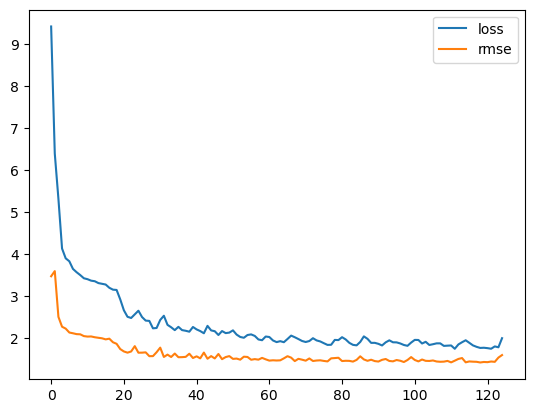

In [12]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [13]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=best_result.config["epoch"],
    extra_eval_set=TST1,
    cv=5,
    verbose=True
)

[CV 4]: 100%|██████████| 125/125 [01:01<00:00,  2.03it/s, loss: 1.811, val_rmse: 1.121]


In [19]:
np.std(result["rmse"]), np.mean(result["rmse"])

(0.64959663, 1.8292319)

In [14]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, MODEL.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, MODEL.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 0.9942076128859046
TST2 : RMSE 1.3021359508377701


In [7]:
def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = AttentiveFP(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        node_feat_size=featurizer.get_node_feat_size(),
        edge_feat_size=featurizer.get_edge_feat_size(),
        graph_feat_size=int(config["graph_feat_size"]),
        num_layers=int(config["num_layers"]),
        num_timesteps=int(config["num_timesteps"]),
        dropout=config["dropout"],
        # General DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=int(config["epoch"]), verbose=False)
    tune.report(rmse=np.average(scores["rmse"]))

In [8]:
SPACE = {
    "num_timesteps": tune.uniform(2, 4),
    "num_layers": tune.uniform(2, 6),
    "graph_feat_size": tune.uniform(100, 300),
    "dropout": tune.uniform(0, 0.5),
    "weight_decay": tune.uniform(0, 0.1),
    "epoch": tune.uniform(100, 500)
}

In [9]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=30,
    search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-14 00:39:43,162	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_9138ed4c,2023-03-14_00-42-59,False,,3e9a52e3b03344a8b8ea25210b43029a,64-4090-13700K,1,127.0.0.1,2212,1.52723,190.538,190.538,190.538,1678754579,0,,1,9138ed4c,0


2023-03-14 01:37:02,788	INFO tune.py:798 -- Total run time: 3436.14 seconds (3435.97 seconds for the tuning loop).


In [10]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'num_timesteps': 3.5657777614123036,
 'num_layers': 3.3567441990248064,
 'graph_feat_size': 142.11642313040966,
 'dropout': 0.3971992048727058,
 'weight_decay': 0.0028966024630566415,
 'epoch': 416.2654156218372}

In [11]:
from model.dgl.AttentiveFP import AttentiveFP

AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = AttentiveFP(
        task_type="regression",
        # AttentiveFP Configuration
        n_tasks=1,
        node_feat_size=featurizer.get_node_feat_size(),
        edge_feat_size=featurizer.get_edge_feat_size(),
        graph_feat_size=200,
        num_layers=5,
        num_timesteps=3,
        dropout=0.3971992048727058,
        # General DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.00289,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=400, min_epoch=250, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 68%|██████▊   | 274/400 [02:33<01:10,  1.79it/s, loss: 1.655 rmse: 1.254]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 72%|███████▎  | 290/400 [02:40<01:00,  1.81it/s, loss: 1.424 rmse: 1.837]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 86%|████████▌ | 342/400 [02:56<00:29,  1.94it/s, loss: 1.438 rmse: 1.685]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 68%|██████▊   | 272/400 [02:35<01:12,  1.75it/s, loss: 1.650 rmse: 0.938]


[INFO] Expect to use 'DGL_Graph-AttentiveFP' to featurize SMILES
[INFO] Device cuda


 72%|███████▏  | 286/400 [02:40<01:04,  1.78it/s, loss: 1.457 rmse: 1.041]


In [12]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [13]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 1.0484425094389709
TST2 : RMSE 1.6461426339604117


In [14]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 0.31403168963726635
TST2 : R^2 0.40924162898604977


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (AttentiveFP)\nRMSE: 1.646, $R^2$: 0.409')

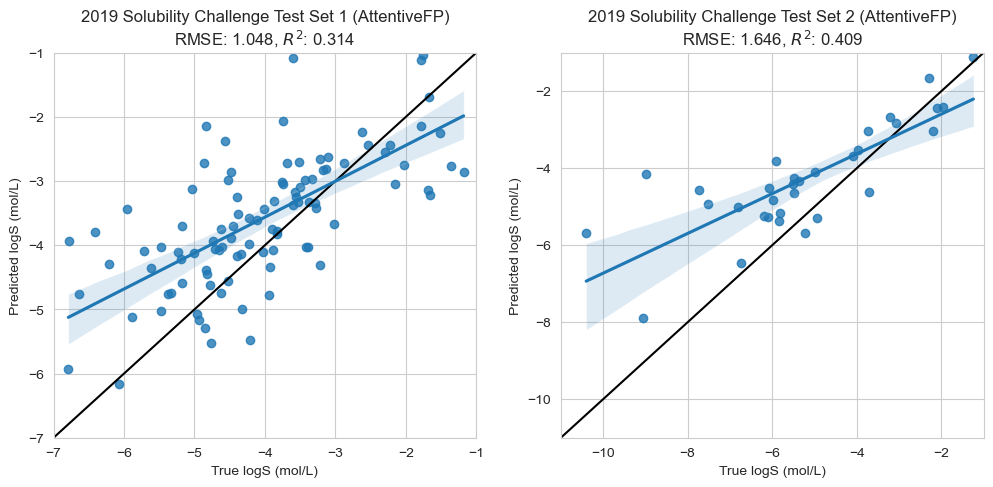

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

model_name = "AttentiveFP"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")